# Generative GNN

In [1]:
import torch
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Traditional Generation techniques

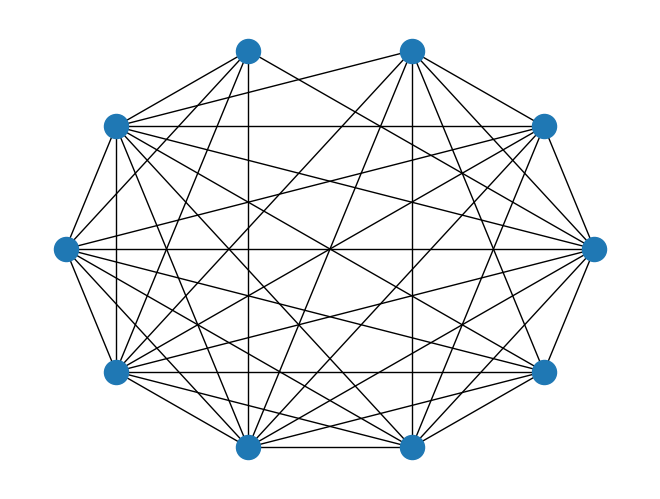

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.erdos_renyi_graph(10, 0.9, seed=0)
pos = nx.circular_layout(G) 
nx.draw(G, pos=pos)

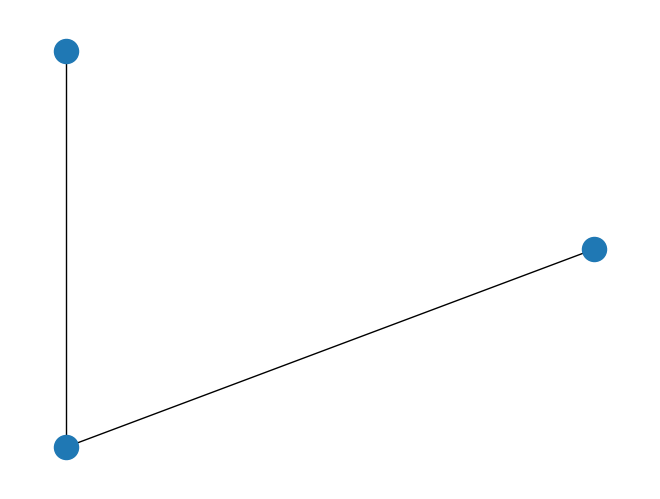

In [3]:
G = nx.gnm_random_graph(3, 2, seed=3)
pos = nx.circular_layout(G) 
nx.draw(G, pos=pos)

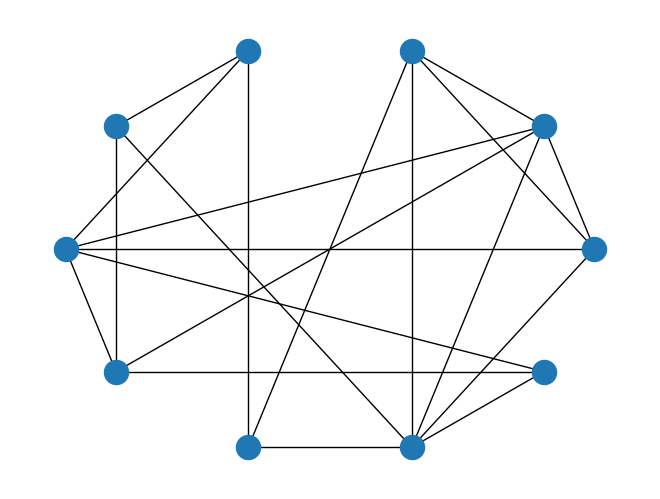

In [4]:
G = nx.watts_strogatz_graph(10, 4, 0.5, seed=0)
pos = nx.circular_layout(G) 
nx.draw(G, pos=pos)

## Graph Variational Autoencoders (GVAE)

In [7]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(
        num_val=0.05, 
        num_test=0.1, 
        is_undirected=True, 
        split_labels=True, 
        add_negative_train_samples=False),
])

dataset = Planetoid('dataset', name='Cora', transform=transform)

train_data, val_data, test_data = dataset[0]

In [8]:
from torch_geometric.nn import GCNConv, VGAE

class Encoder(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.conv1 = GCNConv(dim_in, 2 * dim_out)
        self.conv_mu = GCNConv(2 * dim_out, dim_out)
        self.conv_logstd = GCNConv(2 * dim_out, dim_out)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

model = VGAE(Encoder(dataset.num_features, 16)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index) + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

for epoch in range(301):
    loss = train()
    val_auc, val_ap = test(val_data)
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:>3} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

val_auc, val_ap = test(val_data)
print(f'\nTest AUC: {val_auc:.4f} | Test AP: {val_ap:.4f}')

Epoch:   0 | Val AUC: 0.6729 | Val AP: 0.6988
Epoch:  50 | Val AUC: 0.6667 | Val AP: 0.6744
Epoch: 100 | Val AUC: 0.7042 | Val AP: 0.7104
Epoch: 150 | Val AUC: 0.7445 | Val AP: 0.7584
Epoch: 200 | Val AUC: 0.7767 | Val AP: 0.7875
Epoch: 250 | Val AUC: 0.7960 | Val AP: 0.8082
Epoch: 300 | Val AUC: 0.8345 | Val AP: 0.8524

Test AUC: 0.8345 | Test AP: 0.8524


In [9]:
z = model.encode(test_data.x, test_data.edge_index)
adj = torch.where((z @ z.T) > 0.9, 1, 0)
adj

tensor([[1, 0, 0,  ..., 0, 1, 1],
        [0, 1, 1,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 1, 1],
        [1, 0, 0,  ..., 0, 1, 1]], device='cuda:0')

## Visualization Generated Adjacency 

생성된 그래프의 인접 행렬:
tensor([[1, 0, 0,  ..., 0, 1, 1],
        [0, 1, 1,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 1, 1],
        [1, 0, 0,  ..., 0, 1, 1]], device='cuda:0')


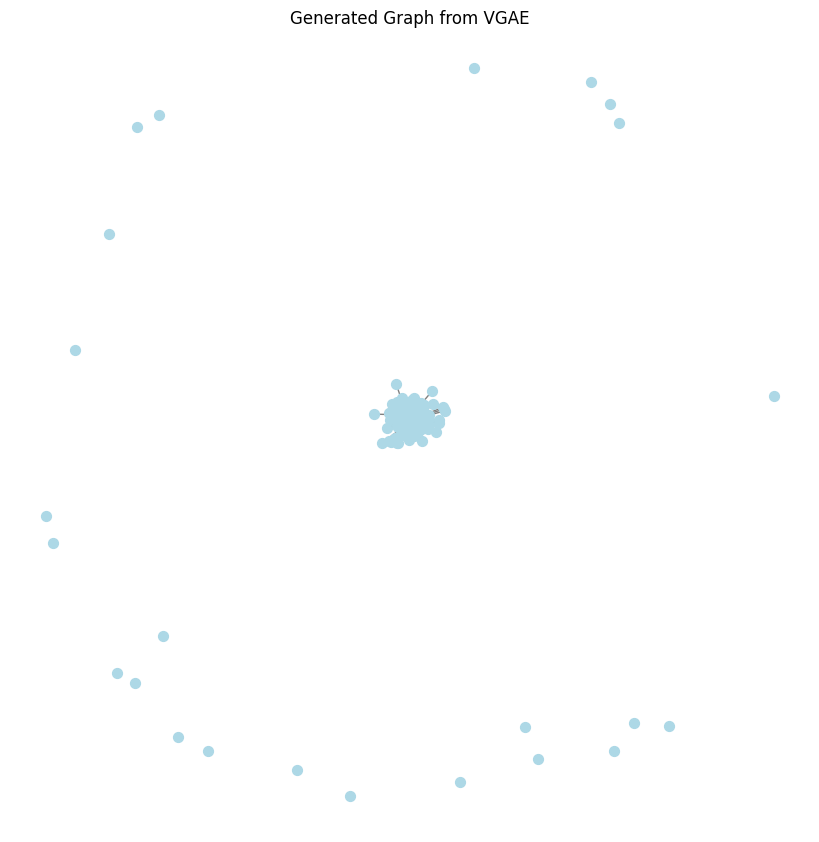


생성된 그래프의 기본 정보:
Number of nodes: 2708
Number of edges: 548173
Is directed: False
Is connected: False


In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. 생성된 그래프의 인접 행렬 확인
print("생성된 그래프의 인접 행렬:")
print(adj)

# 2. 인접 행렬을 NetworkX 그래프로 변환
G = nx.from_numpy_array(adj.cpu().numpy())

# 3. 그래프 시각화
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42)  # 레이아웃 설정
nx.draw(
    G, pos, 
    node_size=50, 
    with_labels=False, 
    edge_color='gray', 
    node_color='lightblue'
)
plt.title("Generated Graph from VGAE")
plt.show()

# 4. 그래프의 기본 정보 출력
print("\n생성된 그래프의 기본 정보:")
print(f"Number of nodes: {G.number_of_nodes()}")  # 노드 수
print(f"Number of edges: {G.number_of_edges()}")  # 엣지 수
print(f"Is directed: {nx.is_directed(G)}")  # 방향성 여부
print(f"Is connected: {nx.is_connected(G)}")  # 연결성 여부

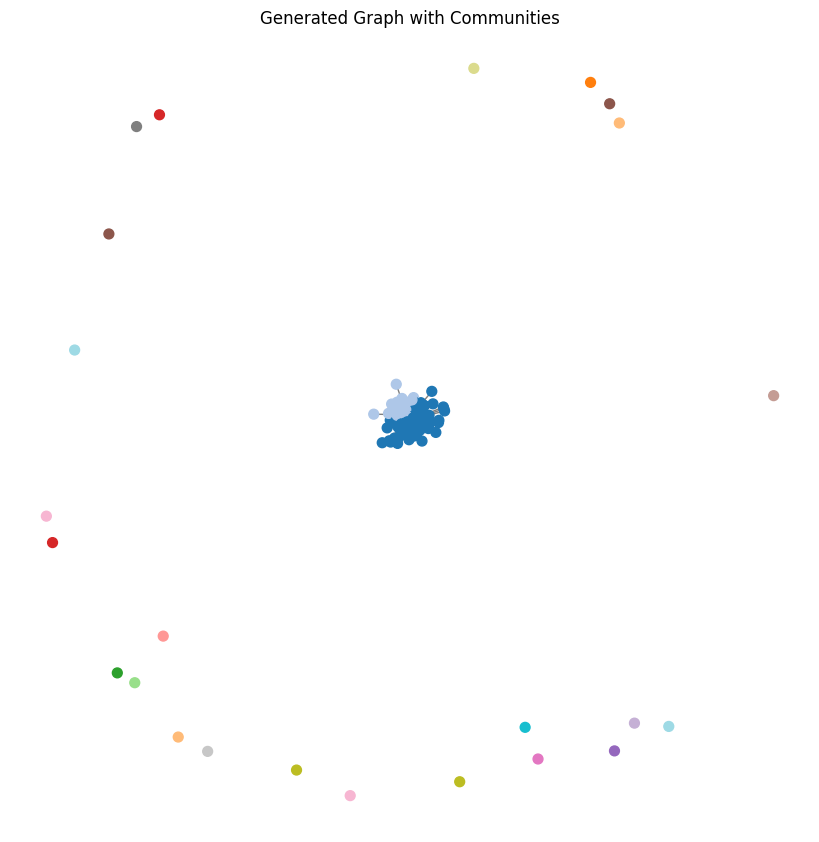

In [14]:
# 커뮤니티 탐지
communities = nx.community.greedy_modularity_communities(G)
community_map = {node: i for i, comm in enumerate(communities) for node in comm}
node_colors = [community_map[node] for node in G.nodes()]

# 커뮤니티별 색상으로 시각화
plt.figure(figsize=(8, 8))
nx.draw(
    G, pos, 
    node_size=50, 
    with_labels=False, 
    edge_color='gray', 
    node_color=node_colors, 
    cmap=plt.cm.tab20)
plt.title("Generated Graph with Communities")
plt.show()